# Data cleaning & Analysis

In [1]:
import pandas as pd
import sklearn as sk
import json

In [2]:
#import the original dataset, the orginal data is due to privacy excluded. 
df = pd.read_csv(r"Files/Career_portfolio_sample2.csv", sep =';', engine ='python', encoding='utf-8', error_bad_lines=False)

## Replace named entities 
Using Spacy entity recognition to ensure privacy

In [3]:
### Import the needed libraries
import spacy
import numpy as np
from spacy.lang.nl.examples import sentences 
from spacy import displacy
from collections import Counter
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint

import nl_core_news_md
nlp = nl_core_news_md.load()

In [4]:
def replace_entity():
    text = df['Dit ben ik']
    text_list = []
    
    for s in text: 
        if s is not np.nan:
            doc = nlp(s)
            newString = s

            ### This piece of code handles one STRING at a time 
            for e in reversed(doc.ents): #reversed to not modify the offsets of other entities when substituting
                start = e.start_char
                end = start + len(e.text)
                newString = newString[:start] + e.label_ + newString[end:]
            edited_sentence = newString
            text_list.append(edited_sentence)
        else: 
            text_list.append('NaN')
            
    df.insert(20, 'converted_about', text_list, True)
    return print('done')

In [5]:
replace_entity()

done


## Clean the dataset

In [6]:
### Catecorize the educational level ### 
def clean_leerweg(x):
    if x=='Basisberoepsgerichte leerweg':
        return 1
    if x=='Kaderberoepsgerichte leerweg':
        return 2
    if x=='Gemengde leerweg':
        return 3
    if x=='Theoretische leerweg':
        return 4
    if x=='Havo':
        return 5
    if x=='Vwo':
        return 6
    if x=='Atheneum':
        return 7
    if x=='Gymnasium':
        return 8
    if x=='Technasium':
        return 9

For now I am going to work with only a part of the dataset therefore some columns will be deleted 

In [7]:
### Clean the dataset ###
import numpy as np
from sklearn.preprocessing import LabelEncoder

def clean_dataframe(df):
    
    ## Remove NaN values and drop unnecessary columns ##
    df_clean = df.dropna(axis=1, how='all')
    df_clean = df_clean.drop(['Naam', 'Bedrijf', 'Functie', 'E-mail', 'In gesprek met', 'Activiteit', 'Periode', 'Waar', 'Uren', 'Omschrijving', 'Plaatje.1', 'Video.1'], axis=1) # Delete the personal information of the internship contact
    
    ## Convert columns to boolean and INT's ##
    df_clean['Foto'] = df_clean['Foto'].isna().astype(int) # 0 contains an input, 1 does not contain an input
    df_clean['Plaatje'] = df_clean['Plaatje'].isna().astype(int) # 0 contains an input, 1 does not contain an input
    df_clean['Video'] = df_clean['Video'].isna().astype(int) # 0 contains an input, 1 does not contain an input
    
    ## Convert 'Leerweg' (educational level) to numbers ##
    ## Source: https://www.rijksoverheid.nl/onderwerpen/voortgezet-onderwijs/vraag-en-antwoord/hoe-zit-het-vmbo-in-elkaar, https://www.onderwijsconsument.nl/niveaus-voortgezet-onderwijs/
      
    df_clean['Leerweg'] = df_clean['Leerweg'].apply(lambda x: clean_leerweg(x))
    
    df = df_clean # The cleaned dataframe is equal to  df, therefore the result can be returned
    
    return df

In [8]:
df = clean_dataframe(df)

## Sentiment on Lexicon

In [9]:
# Insert lexicon's for positive and negative words

text_file_pos = open(r"Files/Lexicon/positive_words_nl.txt", "r")
text_file_neg = open(r'Files/Lexicon/negative_words_nl.txt', 'r')

lines_pos = text_file_pos.readlines()
lines_pos = [s.replace('\n', '') for s in lines_pos]
lines_neg = text_file_neg.readlines()
lines_neg = [s.replace('\n', '') for s in lines_neg]

print('The positive lexicon contains ', (len(lines_pos)), ' inputs.')
print('The negative lexicon contains ', (len(lines_neg)), ' inputs.')

The positive lexicon contains  1502  inputs.
The negative lexicon contains  2474  inputs.


In [10]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def get_POS_tags(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV,}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w, get_POS_tags(w)) for w in nltk.word_tokenize(text)]

In [11]:
def add_sentiment(df): 
     
    df["Dit ben ik"] = df["Dit ben ik"].astype(str)
    text = df["Dit ben ik"]
    lem_text = text.apply(lemmatize_text)
    
    sent_list = [] 
    
    for line in lem_text:
        this_count = 0
   
        for ref_word in line: 

            if ref_word in lines_pos :
                this_count += 1  
            elif ref_word in lines_neg: 
                this_count += -1
            else:
                this_count +=0

        sent_list.append(this_count)    
  
    return sent_list

In [12]:
sent_list = add_sentiment(df)
df.loc[:,'sentiment_score'] = sent_list

## Simple text features 

In [13]:
def word_count(df):
    df['word_count'] = df['Dit ben ik'].apply(lambda x: len(str(x).split(" ")))
    return df[['converted_about','word_count']].head() #To have a look at the results.

In [14]:
word_count(df)

,converted_about,word_count
0,"ik ben PERSON, ik ben DATE, mijn hobbyÕs zijn ...",23
1,Ik ben PERSON uit GPE. Ik zit in klas PERSON E...,20
2,ik ben PERSON. ik ben DATE. mijn hobby en spor...,80
3,"Ik ben PERSON, ik ben DATE. Ik heb kleinere CA...",62
4,Ik ben PERSON en ik woon in GPE. ik ben jarig...,15


In [15]:
def char_count(df):
    df['char_count'] = df['Dit ben ik'].str.len() #This includes spaces as well.
    return df[['converted_about','char_count']].head() #To have a look at the results.

In [16]:
char_count(df)

,converted_about,char_count
0,"ik ben PERSON, ik ben DATE, mijn hobbyÕs zijn ...",113
1,Ik ben PERSON uit GPE. Ik zit in klas PERSON E...,94
2,ik ben PERSON. ik ben DATE. mijn hobby en spor...,388
3,"Ik ben PERSON, ik ben DATE. Ik heb kleinere CA...",306
4,Ik ben PERSON en ik woon in GPE. ik ben jarig...,75


In [17]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['Dit ben ik'].apply(lambda x: avg_word(x))
df[['converted_about','avg_word']].head() #To have a look at the results.

,converted_about,avg_word
0,"ik ben PERSON, ik ben DATE, mijn hobbyÕs zijn ...",3.956522
1,Ik ben PERSON uit GPE. Ik zit in klas PERSON E...,3.750000
2,ik ben PERSON. ik ben DATE. mijn hobby en spor...,3.862500
3,"Ik ben PERSON, ik ben DATE. Ik heb kleinere CA...",3.951613
4,Ik ben PERSON en ik woon in GPE. ik ben jarig...,4.357143


In [18]:
df.pop('Dit ben ik')
print('done')

done


In [19]:
df.head(10)

,Student ID,School ID,Regio,Leeftijd,Leerjaar,Leerweg,Foto,Plaatje,Video,Mijn vervolgstap / mijn vervolgkeuze is.1,...,converted_about,Strengths,Weaknesses,Opportunities,Threats,Werkervaring,sentiment_score,word_count,char_count,avg_word
0,162426,145,7,15,4,3,0,0,1,scalda mediavormgeving,...,"ik ben PERSON, ik ben DATE, mijn hobbyÕs zijn ...","Als ik iets graag wil, ga ik er ook echt voor ...",Dat ik soms wat minder motivatie voor dingen k...,Ik kan misschien ontwerper worden voor bedrijv...,Misschien verdient het niet genoeg geld? Omdat...,Ik heb nog geen werk gehad,0,23,113,3.956522
1,162429,145,7,16,4,3,0,0,1,ik kies voor mijn vervolg opleiding CIOS in Goes.,...,Ik ben PERSON uit GPE. Ik zit in klas PERSON E...,Ik ben een sportief en sociale jongen. En ik ...,Ik ben niet echt goed in plannen. Ik zou soms ...,Ik wil graag CIOS doen en daarna wil ik iets d...,"Nou dat er wel genoeg werk is, nadat ik de opl...",Ik heb bij de Jumbo gewerkt van maart 2019 tot...,0,20,94,3.750000
2,162431,145,7,15,4,3,0,0,1,gewoon op mavo blijven en me mavo diploma hal...,...,ik ben PERSON. ik ben DATE. mijn hobby en spor...,Mensen kunnen mij 100 keer uitschelden of iets...,Ik heb totaal geen concentratie en kan niet st...,Loonwerker of hovenier. Ik denk dat ik bij hov...,Loonwerker is nirt vee ij te verdienen dan zou...,ik sta met mijn vader in de keuken in het caf...,2,80,388,3.862500
3,162437,145,7,15,4,3,0,0,1,Als ik mijn mavo diploma heb gehaald ga ik nog...,...,"Ik ben PERSON, ik ben DATE. Ik heb kleinere CA...",Emma: Ik ben sociaal en gezellig. Mama&papa: E...,Emma: Ik heb soms moeite met me lang concentre...,Emma: Ik kan de baan gaan doen die ik al heel ...,Emma: Het is soms een erg gevoelig en moeilijk...,Ik heb weinig werkervaring omdat ik nu niet w...,1,62,306,3.951613
4,162438,145,7,15,4,3,0,0,1,De opleiding fotografie op Grafisch Lyceum in...,...,Ik ben PERSON en ik woon in GPE. ik ben jarig...,"Mezelf: sociaal, vrolijk, behulpzaam Amber:...","Mezelf: lui, jaloers, druk Amber: druk, ong...",Je kan professional fotograaf worden voor een...,Je hebt niet heel veel mogelijkheden omdat je...,"Ik heb geen werkervaring met fotografie, maar...",0,15,75,4.357143
5,162439,145,7,17,4,3,0,0,1,"MBO opleiding bij de Rooien Pannen in Breda, ...",...,PERSON en ik ben DATE geboortedatum : DATE i...,"Behulpzaam, sociaal, positief Richard Eve...",Iets minder goede concentratie Richard Ev...,"Hotelmanagement & Gastronomie, opleiding : pr...",Met kritiek omgaan vindt ik lastig. Richa...,Ik heb een bijbaan bij van der Valk Hotel Mid...,1,59,301,4.673077
6,162441,145,7,16,4,3,0,0,1,Mbo opleiding kindprofessional op Scalda in G...,...,Ik ben PERSON en ik ben DATE. ik zit nu in ORG...,als ik met iets bezig ben en het gaat goed kan...,Ik ben niet zo goed in rekenen. Ik ben ook bes...,Mij lijkt het heel leuk om de hotelschool ople...,Ik vind het bij de opleiding schoonheidsspecia...,Ik geef nu al meer dan 3 jaar les bij het ster...,3,77,375,3.883117
7,162442,145,7,16,4,3,0,0,1,ik denk dat ik het later leuk zou vinden om i...,...,Ik ben PERSON DATE en doe PERSON. Ik wil later...,Behulpzaam en ik zie wanneer ik nodig ben.Nina...,"Best snel jaloers en chagrijnig Nina: stil, so...",Kind proffesional: Na het behalen van je diplo...,Altijd met kinderen bezig dus kan soms ook fru...,Ik heb een keer een dagje meegelopen op de ou...,1,71,387,4.464789
8,162443,145,7,16,4,3,0,1,1,Mijn vervolg keuze is de opleiding handhaver ...,...,Ik ben PERSON ik ben DATE en woon in GPE ik zi...,ik ben een leuke gezellige leerling die het l...,ik heb slechte concentratie en kan soms druk e...,ik ga de opleiding handhaver toezicht en veil...,ik zie geen nadelen op dingen die minder zijn ...,Ik werk nu bij de Action,2,23,100,3.391304
9,162444,145,7,15,4,3,0,0,1,Ik kies voor mijn opleiding installatietechni...,...,Ik ben PERSON. Ik woon in GPE en ik heb CARDIN...,Sociaal en handig,Niet altijd oplettend,"Installatietechniek, ik hoop dat ik na mijn op...",Werken met gasleidingen,Ik werk op 

In [20]:
df.to_csv('portfolio_data_anonymized.csv', index=False)

## Experiences dataset

In [21]:
#Import experiences

#import the original dataset provided by the AI-research group
df_exp = pd.read_csv(r"Files/Student_experiences_sector.csv", sep =';', engine ='python', encoding='utf-8', error_bad_lines=False)

In [22]:
df_exp.head()

,Student ID,Activiteit,Sector,Type_activiteit,Beoordeling
0,162450,Administratie,Economie en Bedrijf,Opendag,3
1,162458,Administratie,Economie en Bedrijf,Opendag,4
2,162431,Agrarisch,Aarde en Milieu,Opendag,3
3,162462,Analist,Exact en Informatica,Opendag,3
4,162469,Analist,Exact en Informatica,Opendag,3


In [23]:
df_exp.sort_values(by='Activiteit')

from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
df_exp['activiteit_id'] = LE.fit_transform(df_exp['Activiteit'])

In [24]:
df_exp.sort_values(by='activiteit_id').head()

,Student ID,Activiteit,Sector,Type_activiteit,Beoordeling,activiteit_id
0,162450,Administratie,Economie en Bedrijf,Opendag,3,0
1,162458,Administratie,Economie en Bedrijf,Opendag,4,0
2,162431,Agrarisch,Aarde en Milieu,Opendag,3,1
3,162462,Analist,Exact en Informatica,Opendag,3,2
4,162469,Analist,Exact en Informatica,Opendag,3,2


In [25]:
df_exp.info(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Student ID       96 non-null     int64 
 1   Activiteit       96 non-null     object
 2   Sector           96 non-null     object
 3   Type_activiteit  96 non-null     object
 4   Beoordeling      96 non-null     int64 
 5   activiteit_id    96 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 4.6+ KB


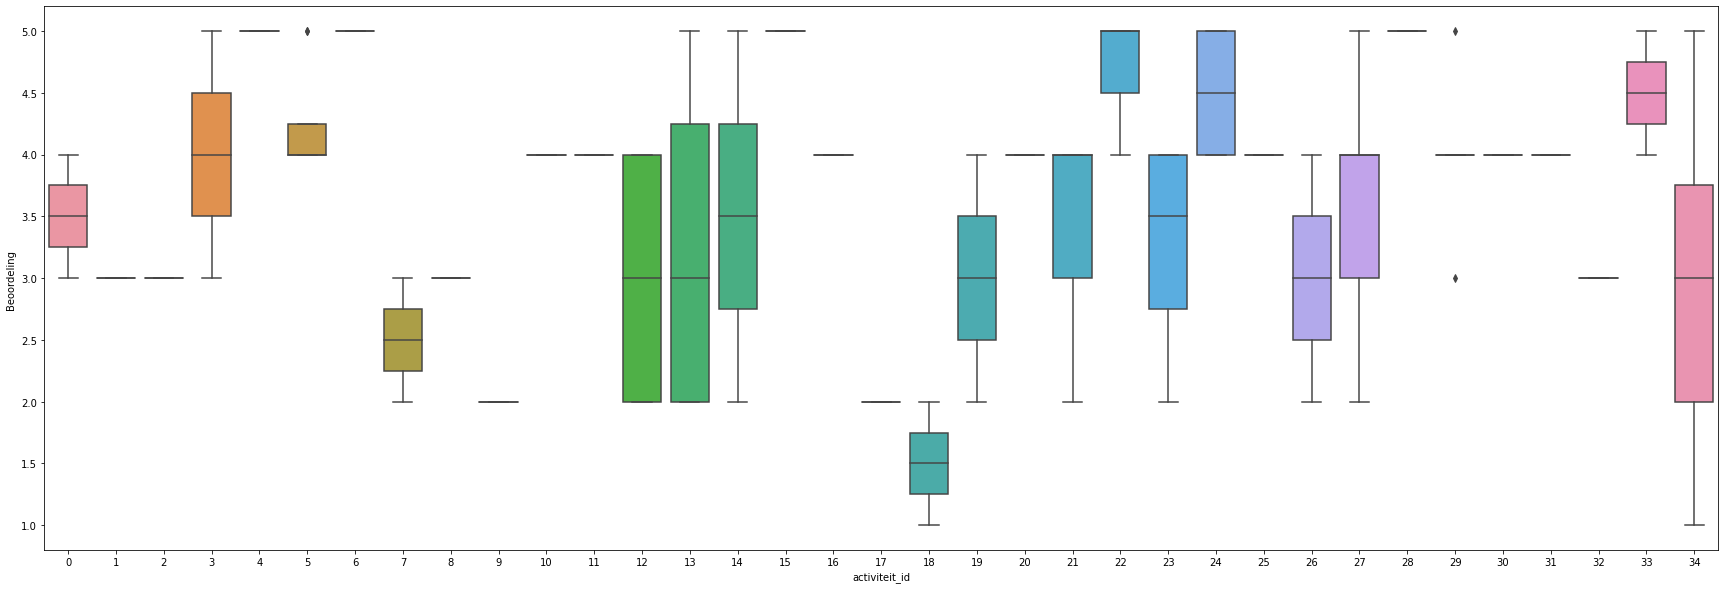

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

fig_dims = (30, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='activiteit_id', y='Beoordeling ', ax=ax, data=df_exp)
plt.show()

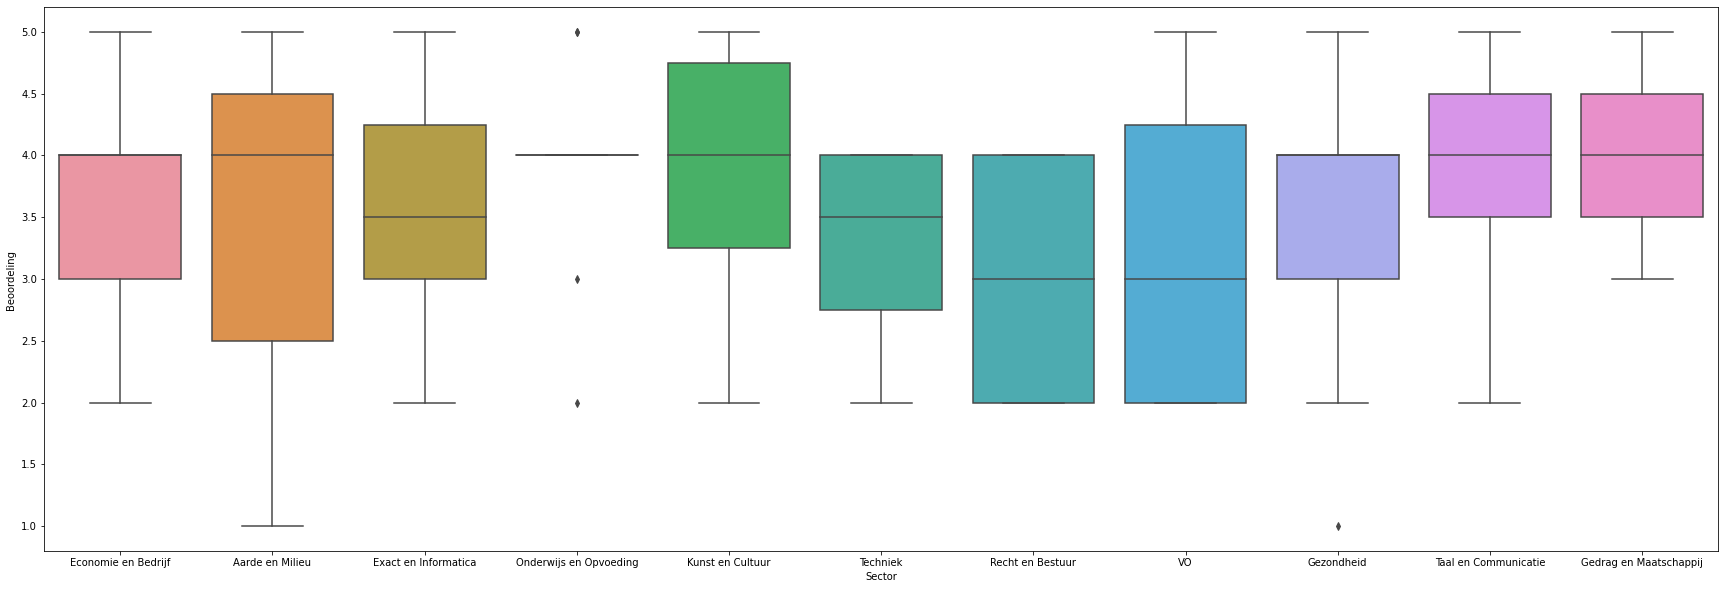

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

fig_dims = (30, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='Sector', y='Beoordeling ', ax=ax, data=df_exp)
plt.show()

<AxesSubplot:>

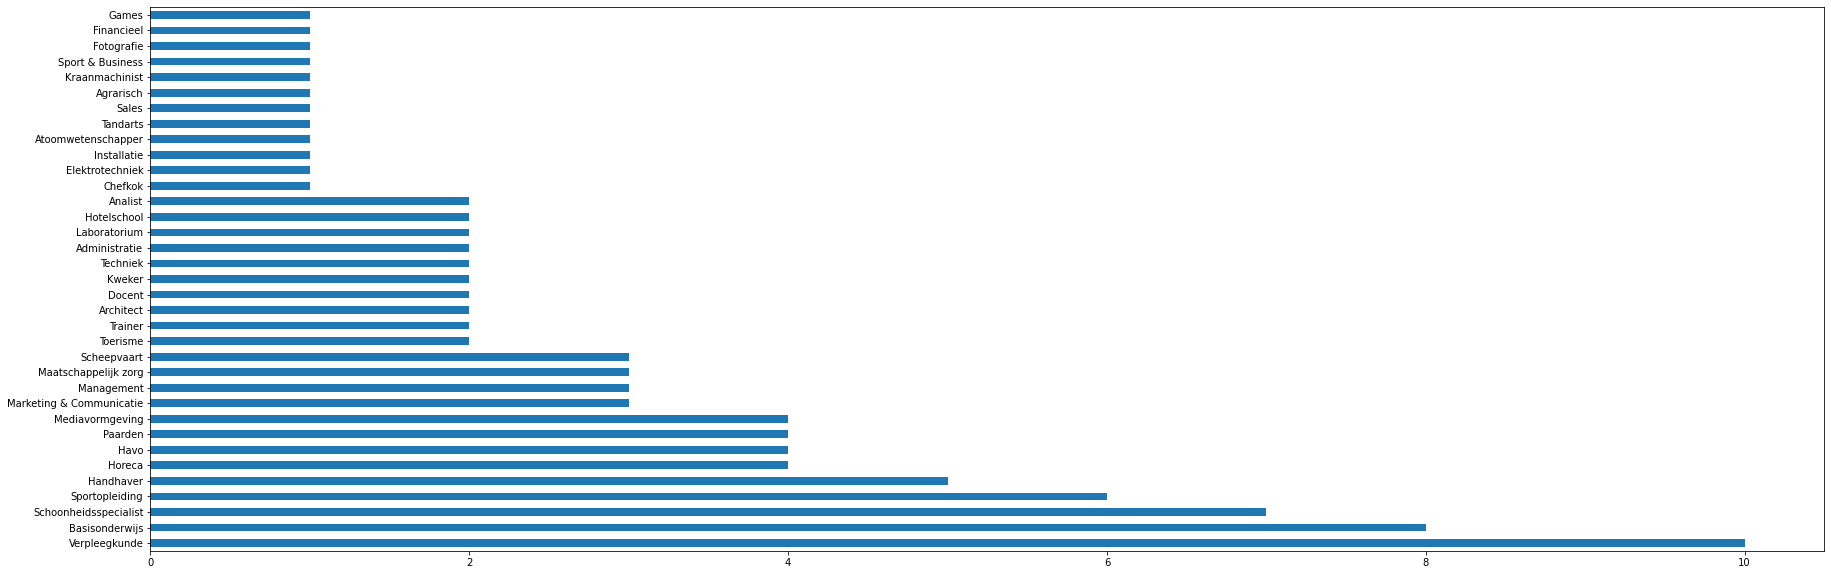

In [28]:
df_exp['Activiteit'].value_counts().plot(kind='barh', figsize=(30,10))

<AxesSubplot:>

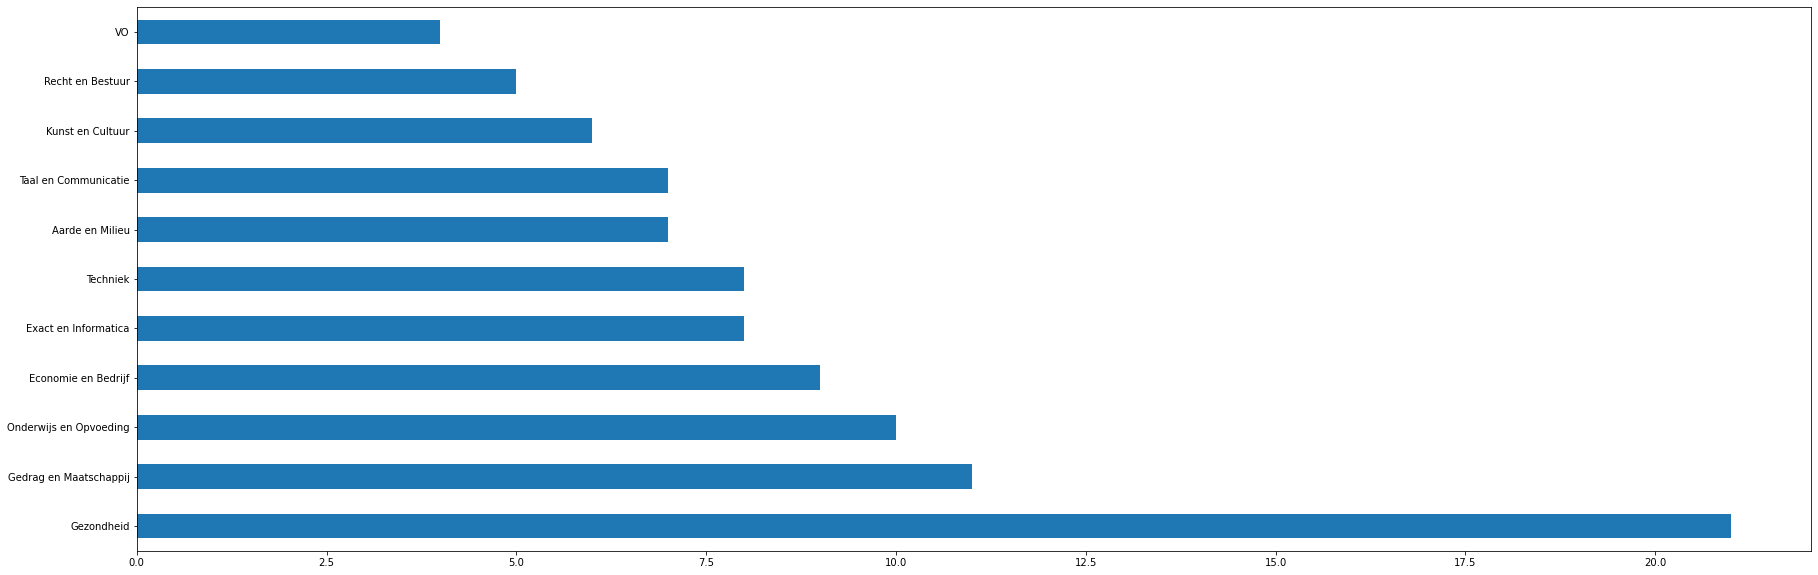

In [29]:
df_exp['Sector'].value_counts().plot(kind='barh', figsize=(30,10))

In [30]:
df_exp['Sector'].value_counts()

Gezondheid                21
Gedrag en Maatschappij    11
Onderwijs en Opvoeding    10
Economie en Bedrijf        9
Exact en Informatica       8
Techniek                   8
Aarde en Milieu            7
Taal en Communicatie       7
Kunst en Cultuur           6
Recht en Bestuur           5
VO                         4
Name: Sector, dtype: int64